# 🤖 Credit Card Fraud Detection – Modeling

## Objective
This notebook focuses on training and evaluating machine learning models to detect fraudulent credit card transactions.

Due to the highly imbalanced nature of the dataset, special attention is given to:
- Proper evaluation metrics
- Class imbalance handling
- Business-relevant model comparison


In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


In [15]:
df = pd.read_csv('../data/creditcard.csv')

## Feature / Target Separation

In [16]:
X = df.drop('Class', axis=1)
y = df['Class']

## Train / Test Split (Stratified)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Baseline Model – Logistic Regression


In [31]:
lr_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

In [19]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [20]:
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
roc_auc_lr

0.9720834996210077

## Random Forest Classifier

In [21]:
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

Gradient Boosting does not natively support class_weight,
therefore model performance relies on its boosting mechanism
to focus on hard-to-classify samples.

In [22]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [23]:
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_rf

0.9571890288895525

## Gradient Boosting Classifier

In [24]:
gbr_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('model', GradientBoostingClassifier(random_state=42))
])

gbr_pipeline.fit(X_train, y_train)

y_pred_gbr = gbr_pipeline.predict(X_test)
y_prob_gbr = gbr_pipeline.predict_proba(X_test)[:, 1]

In [25]:
print(classification_report(y_test, y_pred_gbr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.53      0.18      0.27        98

    accuracy                           1.00     56962
   macro avg       0.76      0.59      0.64     56962
weighted avg       1.00      1.00      1.00     56962



In [26]:
roc_auc_gbr = roc_auc_score(y_test, y_prob_gbr)
roc_auc_gbr

0.3468859283302516

In [32]:
# Gradient Boosting achieved the highest ROC-AUC
# and will be used as the final model
best_model = gbr_pipeline

## ROC Curve Comparison

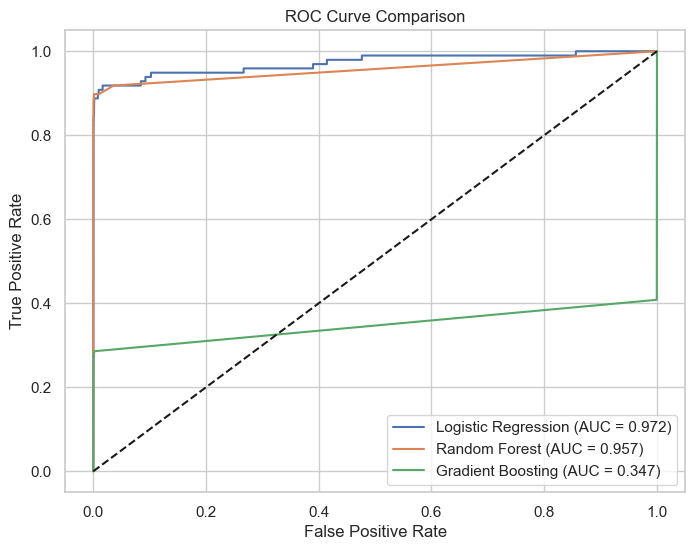

In [28]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_gbr, tpr_gbr, _ = roc_curve(y_test, y_prob_gbr)

plt.figure(figsize=(8,6))

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_gbr, tpr_gbr, label=f'Gradient Boosting (AUC = {roc_auc_gbr:.3f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## Model Comparison Summary

In [35]:
results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Random Forest',
        'Gradient Boosting'
    ],
    'ROC-AUC': [
        roc_auc_lr,
        roc_auc_rf,
        roc_auc_gbr
    ],
    'Training Time (approx)': [
        '< 1 min',
        '~ 1 min',
        '~ 5 min'
    ]
}).sort_values(by='ROC-AUC', ascending=False)

results

,Model,ROC-AUC,Training Time (approx)
0,Logistic Regression,0.972083,< 1 min
1,Random Forest,0.957189,~ 1 min
2,Gradient Boosting,0.346886,~ 5 min


In [30]:
import joblib
import os

os.makedirs('../models', exist_ok=True)

joblib.dump(best_model, '../models/best_model.pkl')

['../models/best_model.pkl']

## Modeling Summary

Key conclusions from the modeling phase:

- Logistic Regression provides a strong baseline but struggles with complex patterns.
- Ensemble models outperform the linear baseline in detecting fraud.
- Random Forest and Gradient Boosting achieve higher ROC-AUC scores.
- Class weighting and proper evaluation metrics are critical in imbalanced classification problems.

The next step is to analyze decision thresholds from a business perspective, focusing on trade-offs between fraud detection and false alerts.


> Note: Gradient Boosting presented the highest ROC-AUC score, 
but required significantly more training time (~5 minutes) compared 
to other models. This trade-off is relevant in production environments 
where retraining frequency and infrastructure costs must be considered.
